## Step 1

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

In [2]:
x = torch.rand(20, 5)
x
((x.norm(dim=1) - 1).abs() < 1e-10).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b

In [4]:
# n_train: 학습 데이터의 샘플 개수(1000개)
n_train = 1000
noise_level = 0.04

# 차원 = 학습 포인트 수 * 입력 차원
# train data: 행렬 & 모든 행은 하나의 샘플이므로 하나의 입력 차원 벡터가 되고 행으로 값 샘플을 수집한 다음 훈련 값으로 사용 후 평가
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# 정규분포(평균 0, 표준편차 1)에서 잡음을 샘플링하고, 이를 noise level로 조정해 y_train에 추가
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

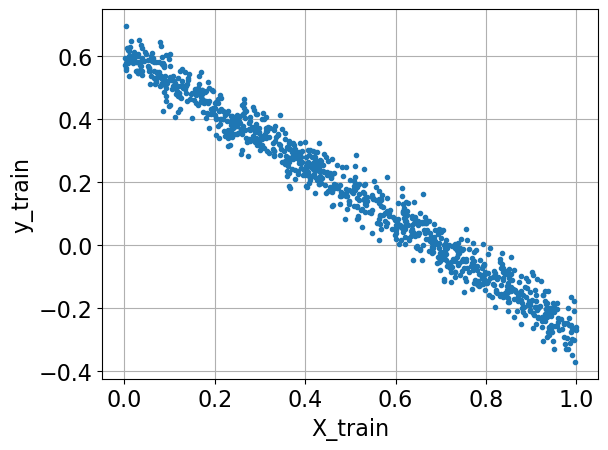

In [5]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

### Plot 해석

#### X_train과 y_train의 관계: 선형 관계 ▶ 대부분의 점들이 선형적인 패턴을 보임(y = Ax + b)
#### 잡음(noise): 선형 관계 주위에 약간의 산란(noise)가 보임
#### why?) y_train에서 잡음이 추가되었기 때문
#### 학습 목표: 모델이 이 데이터를 학습하여 잡음을 무시하고 선형 관계를 잘 추정하는 것이 목표

In [6]:
!pip install utils

In [7]:
# PyTorch의 데이터셋을 상속받아 데이터를 효율적으로 처리할 수 있도록 데이터 정의
# input data와 output data를 텐서로 변환하여 저장 & 크기 제공 & 인덱스를 기반으로 샘플 반환
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
    
    # 1. 데이터의 길이를 제공하는 함수 생성
    def __len__(self):
        return self.input_data.shape[0]
    
    # 2. 위치 인덱스의 요소를 제공하는 항목 생성
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :],
                 self.output_data[idx, :])
        return sample

In [8]:
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
    
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :],
                 self.output_data[idx, :])
        return sample

In [9]:
# input data와 output data를 입력으로 받는 training set 생성
training_set = VectorialDataset(input_data = X_train, output_data = y_train)

In [10]:
training_set = VectorialDataset(input_data = X_train, output_data = y_train)

In [11]:
# 1000쌍의 입력-출력
len(training_set)

1000

In [12]:
len(training_set)

1000

In [13]:
training_set[10:12]

(tensor([[0.4172],
         [0.5668]]),
 tensor([[0.2409],
         [0.0503]]))

## Step 2

### PyTorch DataLoader - 파이썬에서 데이터를 처리하는 데 사용되는 두 번째 객체 구성

### 출력 해석: tensor 2개의 의미는 입력과 출력

In [14]:
batch_size = 120
# DataLoader를 사용함으로써 클래스의 객체를 구성 (구성 요소 1: 구성한 train 데이터셋 )
# batch_size: 1000개의 train 데이터셋에서 120개씩 데이터를 가져와 처리
#             GPU, CPU의 메모리 사용량 감소, 효율적인 병렬 연산
# shuffle: 각 epoch가 시작될 때 데이터셋을 무작위로 섞음, 데이터 순서에 의한 편향 방지
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [15]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [16]:
# train_loader가 반복
for idx, batch in enumerate(train_loader):
    # batch[0]: 입력 배치 / batch[1]: 출력 배치
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [17]:
for idx, batch in enumerate(train_loader):
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [18]:
8 * 120

960

In [19]:
first_batch = []

#epoch: 데이터셋에 대한 전체 반복을 n번 수행
for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)
        
np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]
# 첫 번째 열: 데이터 자체(입력 데이터) / 두 번째 열: 첫 번째 반복에서 얻은 첫 번째 batch

array([[0.69620724, 0.34453756, 0.11128139],
       [0.23862192, 0.03966673, 0.47747701],
       [0.82995841, 0.93200135, 0.03325217],
       [0.02228768, 0.1858979 , 0.02758626],
       [0.87627612, 0.73559743, 0.72305131],
       [0.40716075, 0.23558177, 0.52848434],
       [0.15645956, 0.20346519, 0.92700756],
       [0.44788297, 0.9247489 , 0.53107184],
       [0.34539277, 0.81746989, 0.87401724],
       [0.93838247, 0.93612069, 0.4568603 ],
       [0.41720312, 0.62449849, 0.60633594],
       [0.56683675, 0.80511421, 0.75540185],
       [0.40168529, 0.10384285, 0.87115425],
       [0.96879003, 0.38975769, 0.66824573],
       [0.62267637, 0.60633594, 0.26310363],
       [0.27743224, 0.30003268, 0.43471572],
       [0.68722128, 0.35603306, 0.51059687],
       [0.61983037, 0.098242  , 0.96025652],
       [0.30391542, 0.20735092, 0.92512316],
       [0.88540374, 0.5143373 , 0.45416015],
       [0.86341676, 0.19680589, 0.59830999],
       [0.81746987, 0.81214744, 0.20258451],
       [0.

## Step 3: Models

### 선형 모델로 데이터를 복구
### 모델: 입력을 출력에 Mapping  ▶ y = Ax + b
#### 현재 A와 b에 대한 정확한 수치는 모르는 상태, 따라서 앞으로 올바른 매개변수를 찾아 y = Ax + b에 가까워지도록 하는 과정 수행

In [20]:
import torch.nn as nn
import torch

#%% Linear layer
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim #차원 저장
        self.output_dim = output_dim #출력 차원 저장
        
        # 선형 레이어 지정 (Ax+b 유형 제공) / bias(b):편향 ▶ false로 지정 시 b 사라짐
        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x) #모델: 입력을 받아 선형 모델을 평가
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [21]:
model = LinearModel(input_dim, output_dim)

### Model inspection

In [22]:
print(model) #모델: 선형적인 layer 1개

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [23]:
list(model.parameters()) # 첫 번째 tensor: 행렬 A, 두 번째 tensor: 벡터 b

[Parameter containing:
 tensor([[-0.1131]], requires_grad=True),
 Parameter containing:
 tensor([-0.7203], requires_grad=True)]

In [24]:
model.linear.weight

Parameter containing:
tensor([[-0.1131]], requires_grad=True)

In [25]:
model.linear.bias

Parameter containing:
tensor([-0.7203], requires_grad=True)

### The forward method

In [26]:
x = torch.randn(5, input_dim) #5개 입력의 임의 입력을 가져와 계산할 수 있는지 test
model.forward(x)

tensor([[-0.5453],
        [-0.8445],
        [-0.4973],
        [-0.6920],
        [-0.6565]], grad_fn=<AddmmBackward0>)

In [27]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([-0.5453], grad_fn=<AddBackward0>),
 tensor([-0.8445], grad_fn=<AddBackward0>),
 tensor([-0.4973], grad_fn=<AddBackward0>),
 tensor([-0.6920], grad_fn=<AddBackward0>),
 tensor([-0.6565], grad_fn=<AddBackward0>)]

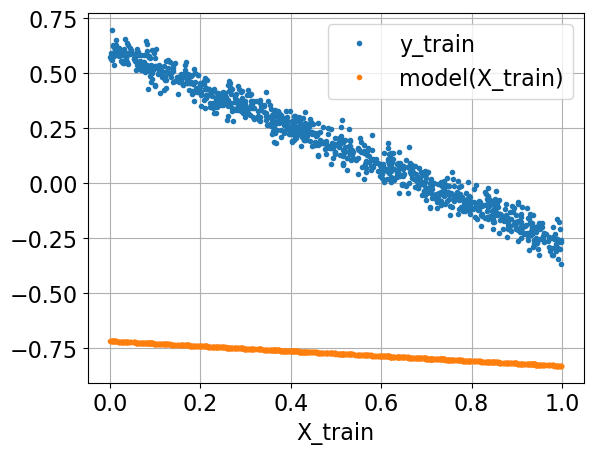

In [28]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])   

### Plot 해석
#### random 형태이기 때문에 좋은 예측이 X
#### 목표: X_train을 y_train에 최대한 가깝게 조정 ▶ how?) 손실함수로 (주로 MSE 이용)

## Losses

### The MSE loss
#### 손실 ▶ 두 벡터 사이의 거리

In [29]:
loss_fun = nn.MSELoss()

In [30]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

In [31]:
#제대로 작동하는지 확인하기 위해 두 개의 무작위 tensor(벡터) 사용
#(1+4+1)/3 = 2x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

#### 하나의 단일 출력 쌍에 대한 손실 평가 ▶ 입력을 받아 모델을 평가한 후 손실 계산

IndexError: list index out of range

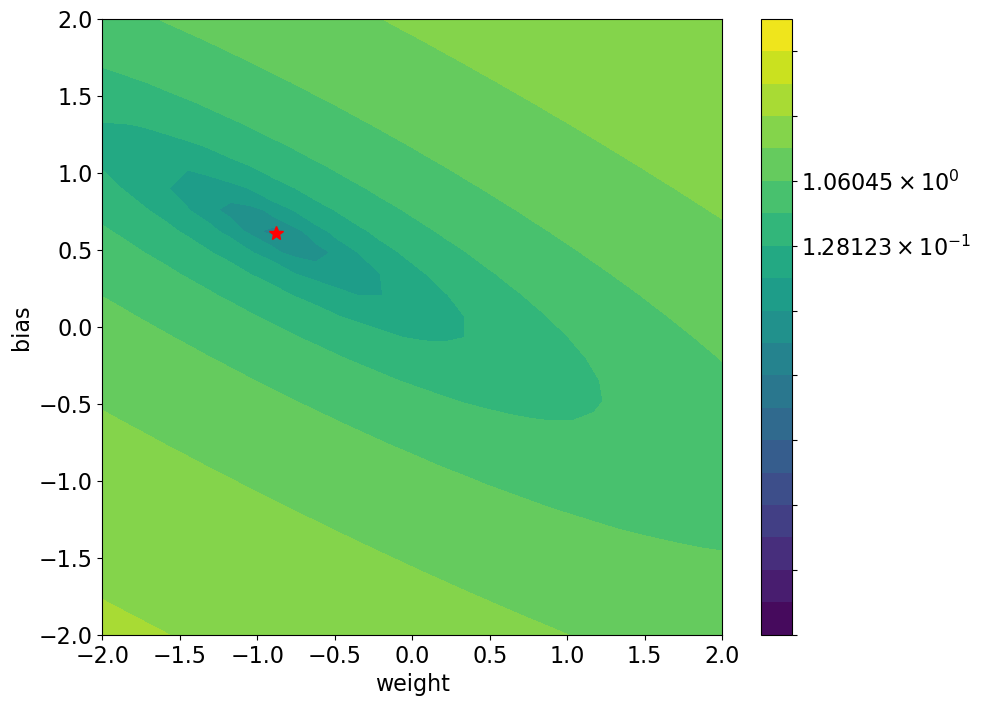

In [32]:
if input_dim == output_dim == 1:
    state_dict = model.state_dict()
    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))
    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data), training_set.output_data)
    fig = plt.figure(figsize = (10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c = ax.contourf(ww, bb, loss_values, levels = levels, norm = colors.LogNorm())
    plt.colorbar(c)
    #red dot: 행렬과 실제 모델의 편향에 의해 정확히 주어지며 실제로 우리가 가까울 때 손실이 매우 작음
    #red dot: 최솟값 X ▶ 약간의 noise가 있고 손실이 이를 고려하지 않았기 때문
    ax.plot(A[0], b, 'r*', markersize = 10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    ax.grid(True)

### Plot 해석
#### 모든 지점에 대해 가중치 & 편향의 단일 입출력 쌍
#### 주황색 선을 생성하는 것은 이미지 어딘가에 있는 지점

In [33]:
# 임의의 1차원의 한 개의 sample
x = torch.randn(1, input_dim)
y = torch.randn(1, output_dim)

model.zero_grad() #모델에 있는 기존의 모든 것들 초기화
loss = loss_fun(model.forward(x), y) #손실함수: 모델 예측을 수행하고 전의 모델과 비교
loss.backward() #무언가의 기울기를 계산할 때 손실의 기울기를 의미

In [34]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[-2.8799]])
tensor([[-2.8799]], grad_fn=<MulBackward0>)
tensor([2.9233])
tensor([[2.9233]], grad_fn=<MulBackward0>)


In [35]:
if input_dim == output_dim == 1:

    num_iter = 200 # 200번 반복을 수행
    lr = 0.5 # 0.01 고정된 학습률을 지정

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

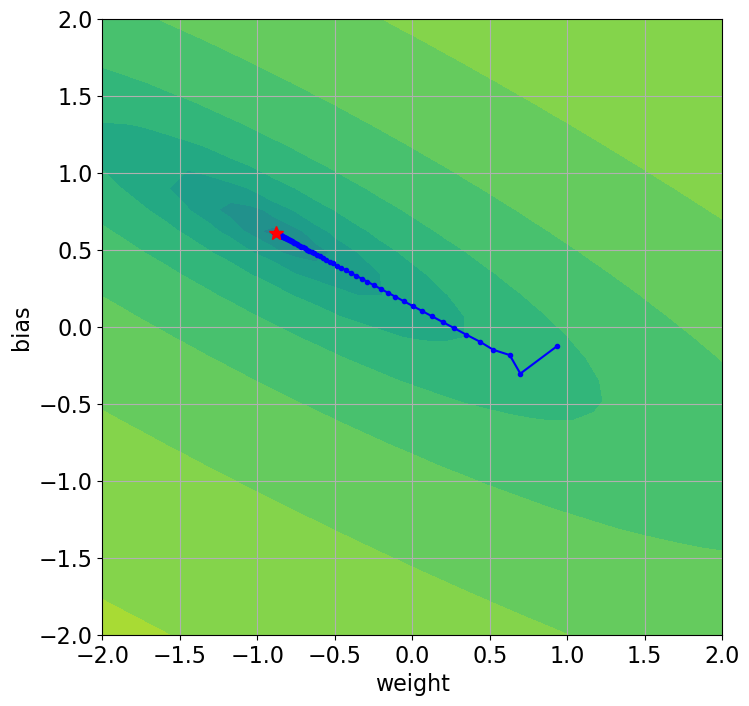

In [36]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    #ax.legend(['optim', '(A, b)'])

In [37]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [38]:
n_epochs = 100

In [39]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
# 최적화 시작 시 다시 임의의 값으로 가중치 초기화
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
        
model.eval()

[Epoch    1/ 100] [Batch    1/   9] Loss:  3.47e-01
[Epoch    1/ 100] [Batch    2/   9] Loss:  2.12e-01
[Epoch    1/ 100] [Batch    3/   9] Loss:  8.99e-02
[Epoch    1/ 100] [Batch    4/   9] Loss:  2.86e-02
[Epoch    1/ 100] [Batch    5/   9] Loss:  1.71e-03
[Epoch    1/ 100] [Batch    6/   9] Loss:  1.16e-02
[Epoch    1/ 100] [Batch    7/   9] Loss:  3.68e-02
[Epoch    1/ 100] [Batch    8/   9] Loss:  6.85e-02
[Epoch    1/ 100] [Batch    9/   9] Loss:  7.61e-02
[Epoch    2/ 100] [Batch    1/   9] Loss:  7.74e-02
[Epoch    2/ 100] [Batch    2/   9] Loss:  6.67e-02
[Epoch    2/ 100] [Batch    3/   9] Loss:  4.76e-02
[Epoch    2/ 100] [Batch    4/   9] Loss:  2.99e-02
[Epoch    2/ 100] [Batch    5/   9] Loss:  1.40e-02
[Epoch    2/ 100] [Batch    6/   9] Loss:  4.51e-03
[Epoch    2/ 100] [Batch    7/   9] Loss:  2.16e-03
[Epoch    2/ 100] [Batch    8/   9] Loss:  5.25e-03
[Epoch    2/ 100] [Batch    9/   9] Loss:  8.84e-03
[Epoch    3/ 100] [Batch    1/   9] Loss:  1.97e-02
[Epoch    3/

[Epoch   26/ 100] [Batch    6/   9] Loss:  1.40e-03
[Epoch   26/ 100] [Batch    7/   9] Loss:  1.45e-03
[Epoch   26/ 100] [Batch    8/   9] Loss:  1.88e-03
[Epoch   26/ 100] [Batch    9/   9] Loss:  2.31e-03
[Epoch   27/ 100] [Batch    1/   9] Loss:  1.35e-03
[Epoch   27/ 100] [Batch    2/   9] Loss:  1.99e-03
[Epoch   27/ 100] [Batch    3/   9] Loss:  1.62e-03
[Epoch   27/ 100] [Batch    4/   9] Loss:  1.59e-03
[Epoch   27/ 100] [Batch    5/   9] Loss:  1.48e-03
[Epoch   27/ 100] [Batch    6/   9] Loss:  1.50e-03
[Epoch   27/ 100] [Batch    7/   9] Loss:  1.80e-03
[Epoch   27/ 100] [Batch    8/   9] Loss:  1.84e-03
[Epoch   27/ 100] [Batch    9/   9] Loss:  1.81e-03
[Epoch   28/ 100] [Batch    1/   9] Loss:  1.64e-03
[Epoch   28/ 100] [Batch    2/   9] Loss:  1.48e-03
[Epoch   28/ 100] [Batch    3/   9] Loss:  2.02e-03
[Epoch   28/ 100] [Batch    4/   9] Loss:  2.00e-03
[Epoch   28/ 100] [Batch    5/   9] Loss:  1.43e-03
[Epoch   28/ 100] [Batch    6/   9] Loss:  1.56e-03
[Epoch   28/

[Epoch   52/ 100] [Batch    2/   9] Loss:  1.73e-03
[Epoch   52/ 100] [Batch    3/   9] Loss:  1.71e-03
[Epoch   52/ 100] [Batch    4/   9] Loss:  1.78e-03
[Epoch   52/ 100] [Batch    5/   9] Loss:  1.54e-03
[Epoch   52/ 100] [Batch    6/   9] Loss:  1.52e-03
[Epoch   52/ 100] [Batch    7/   9] Loss:  1.68e-03
[Epoch   52/ 100] [Batch    8/   9] Loss:  1.66e-03
[Epoch   52/ 100] [Batch    9/   9] Loss:  1.90e-03
[Epoch   53/ 100] [Batch    1/   9] Loss:  1.48e-03
[Epoch   53/ 100] [Batch    2/   9] Loss:  1.43e-03
[Epoch   53/ 100] [Batch    3/   9] Loss:  1.43e-03
[Epoch   53/ 100] [Batch    4/   9] Loss:  1.76e-03
[Epoch   53/ 100] [Batch    5/   9] Loss:  1.54e-03
[Epoch   53/ 100] [Batch    6/   9] Loss:  1.90e-03
[Epoch   53/ 100] [Batch    7/   9] Loss:  1.81e-03
[Epoch   53/ 100] [Batch    8/   9] Loss:  1.88e-03
[Epoch   53/ 100] [Batch    9/   9] Loss:  1.83e-03
[Epoch   54/ 100] [Batch    1/   9] Loss:  1.84e-03
[Epoch   54/ 100] [Batch    2/   9] Loss:  1.55e-03
[Epoch   54/

[Epoch   77/ 100] [Batch    2/   9] Loss:  1.80e-03
[Epoch   77/ 100] [Batch    3/   9] Loss:  1.63e-03
[Epoch   77/ 100] [Batch    4/   9] Loss:  1.58e-03
[Epoch   77/ 100] [Batch    5/   9] Loss:  1.72e-03
[Epoch   77/ 100] [Batch    6/   9] Loss:  1.86e-03
[Epoch   77/ 100] [Batch    7/   9] Loss:  1.62e-03
[Epoch   77/ 100] [Batch    8/   9] Loss:  1.85e-03
[Epoch   77/ 100] [Batch    9/   9] Loss:  2.22e-03
[Epoch   78/ 100] [Batch    1/   9] Loss:  1.56e-03
[Epoch   78/ 100] [Batch    2/   9] Loss:  2.29e-03
[Epoch   78/ 100] [Batch    3/   9] Loss:  1.81e-03
[Epoch   78/ 100] [Batch    4/   9] Loss:  1.93e-03
[Epoch   78/ 100] [Batch    5/   9] Loss:  1.45e-03
[Epoch   78/ 100] [Batch    6/   9] Loss:  1.63e-03
[Epoch   78/ 100] [Batch    7/   9] Loss:  1.51e-03
[Epoch   78/ 100] [Batch    8/   9] Loss:  1.90e-03
[Epoch   78/ 100] [Batch    9/   9] Loss:  1.99e-03
[Epoch   79/ 100] [Batch    1/   9] Loss:  1.39e-03
[Epoch   79/ 100] [Batch    2/   9] Loss:  1.38e-03
[Epoch   79/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [40]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())

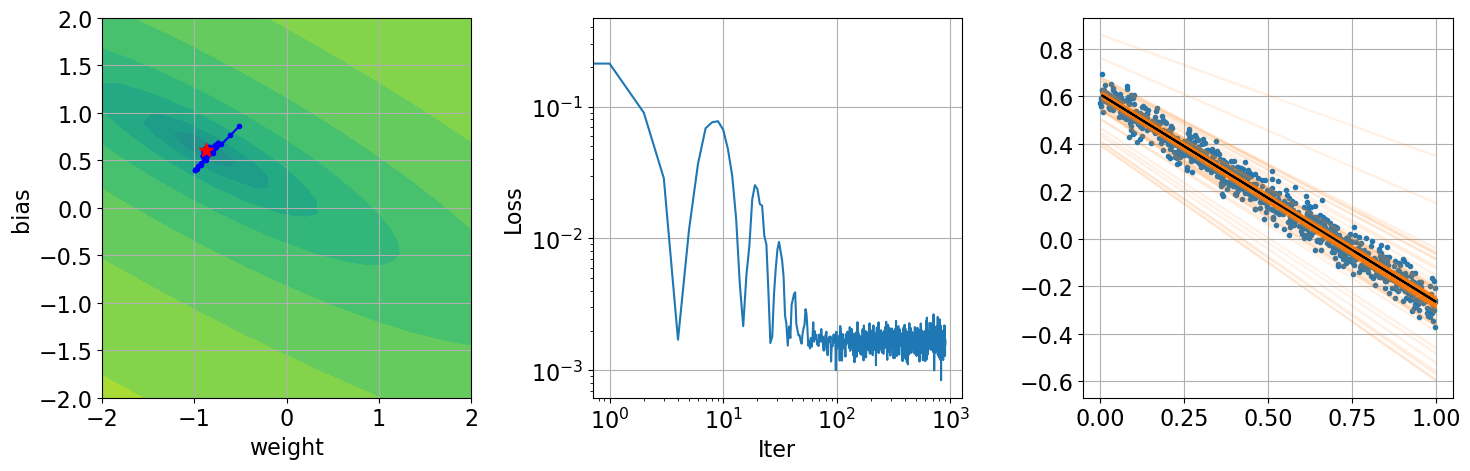

In [41]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    #ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)

### Plot 해석

#### 첫 번째: 계수의 진화에 대한 동작 ▶ 궤적을 따라 최소값으로 이동 (Adam에 의해 계산된 궤적) / 손실이 단조롭게 감소 X
#### 두 번째: 손실 값 (log-log plot) ▶ Gradiant의 확률적 계산으로 인해 정확히 발생 / 근사치이지만 이대로 봐도 괜춘! / 모델이 계속 진동
#### 세 번째: 파란색(데이터셋) / 검은색(최종) / 주황색(모터의 진화과정?)